In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from plotting import *
import mydelfi
from mydelfi.ndes import *
from mydelfi.mdn import *

In [4]:
tfp.__version__

'0.21.0'

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# import data
theta_ = (np.load('tpcf_params.npy').astype(np.float32))
summaries_ = np.load('tpcf_data.npy').astype(np.float32)[:, ::4] # take every 4th pk bin


weights = np.ones((summaries_.shape[0], 1)).astype(np.float32)

# bijector theta -> phi
theta_min = [0.05, 0.45, 0.59]
theta_max = [0.5, 0.9, 1.0]
bijector = tfb.Blockwise([tfb.Chain([tfb.Invert(tfb.NormalCDF()), tfb.Scale(np.float32(1./(theta_max[_] - theta_min[_]))), tfb.Shift(-theta_min[_])]) for _ in range(len(theta_min))])

# phi
phi_ = bijector(theta_).numpy()

In [7]:
theta = tf.convert_to_tensor(theta_, dtype=tf.float32)
phi   = tf.convert_to_tensor(phi_, dtype=tf.float32)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)
summaries = tf.convert_to_tensor(summaries_, dtype=tf.float32)

In [8]:
# Amortized posterior
filename = 'amort_quijote'
AmortizedPosterior = MixtureDensityNetwork2(n_components=5, 
                            n_conditionals=56, # number of p(k) summaries
                            n_dimensions=3,  # number of parameters
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                            n_hidden=[64, 64],
                            activation=[tf.tanh, tf.tanh])

/Users/lucas/venvs/mydelfi/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
#AmortizedPosterior.optimizer = tf.keras.optimizers.Adam(lr=1e-3)
historyAP = AmortizedPosterior.fit(training_conditionals=summaries, training_variables=phi, training_weights=weights, 
                        epochs=3000, batch_size=100, patience=500, save=True, filename=filename)

 17%|█████████▌                                               | 503/3000 [00:24<02:03, 20.22it/s, training loss=0.851, validation_loss=1.87]


In [17]:
# reload best model
AmortizedPosterior = MixtureDensityNetwork2(n_components=5, 
                            n_conditionals=56, 
                            n_dimensions=3, 
                            optimizer=tf.keras.optimizers.Adam(lr=5e-5),
                            n_hidden=[64, 64],
                            activation=[tf.tanh, tf.tanh],
                            restore=True,
                            restore_filename=filename)

In [27]:
# choose the first sim as our target data
target_idx = 1

summaries_obs = summaries_[target_idx]

In [28]:
Posterior = AmortizedPosterior.distribution(summaries_obs[np.newaxis, :].astype(np.float32))

posterior_samples = bijector.inverse(Posterior.sample(100000)).numpy()
cut = np.all(~np.isinf(posterior_samples), axis=-1)
posterior_samples = posterior_samples[cut,:]

(array([2.0000e+00, 1.3700e+02, 3.0280e+03, 2.3179e+04, 4.6323e+04,
        2.4036e+04, 2.9190e+03, 4.2000e+01, 0.0000e+00, 3.3400e+02]),
 array([0.21006617, 0.23889728, 0.26772839, 0.29655951, 0.32539061,
        0.3542217 , 0.38305283, 0.41188395, 0.44071504, 0.46954614,
        0.49837726]),
 <BarContainer object of 10 artists>)

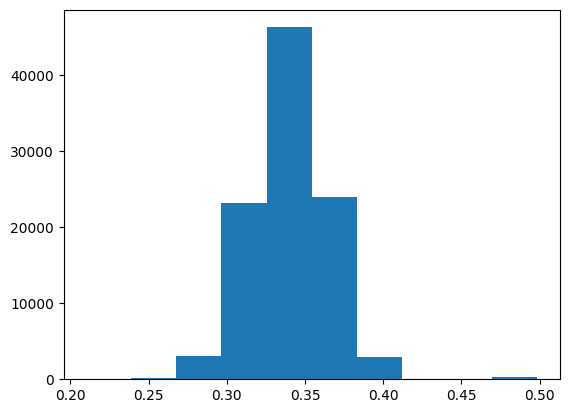

In [29]:
plt.hist(posterior_samples[:, 0])

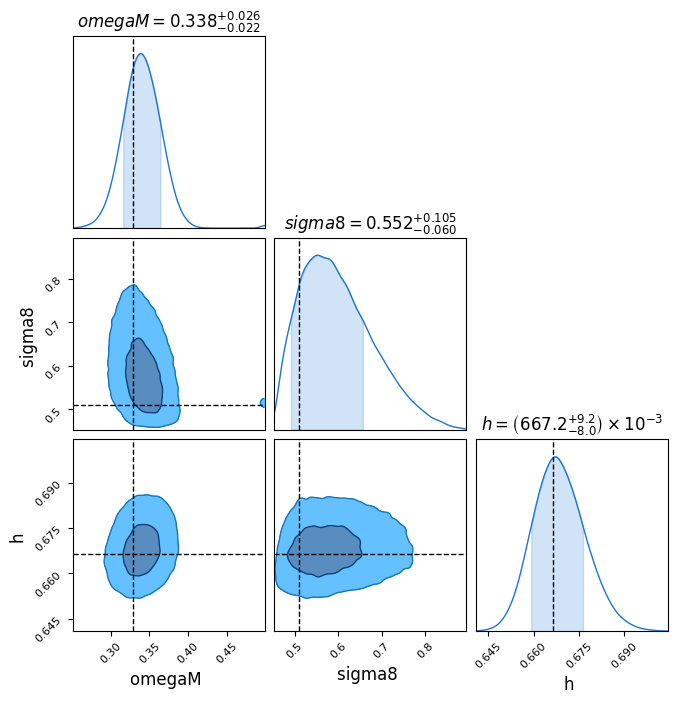

In [30]:
from chainconsumer import ChainConsumer

_psts = posterior_samples.copy()
#_psts[:, 0] = 0.3*(posterior_samples[:, 0]**2 / posterior_samples[:, 1]**2)

cs = ChainConsumer()
cs.add_chain(_psts, parameters=['omegaM', 'sigma8', 'h'], name='DELFI') #, color=corner_colors[0])
#cs.add_covariance(θ_target, -Finv_analytic, parameters=params, name="Analytic Fisher", color=corner_colors[2])
cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=True)
cs.plotter.plot((7,7), truth=theta_[target_idx])
plt.show()

# now set up PIT coverage tests

for every pair (theta*, data*) in the training set, for each of the marginals compute P(theta < theta* | data*), and plot the distribution of those cumulative probabilities

In [31]:
from tqdm import tqdm

In [39]:
omegam_cdfs = []
sigma8_cdfs = []
h_cdfs = []

for i in tqdm(range(1600)):
  theta_i = theta_[i]
  summary_i = summaries_[i]
  # could add tfp mixture model here for more than one MDN
  # p(theta | x)
  dist = AmortizedPosterior.distribution(summary_i[np.newaxis, :].astype(np.float32))
  
  samps = bijector.inverse(dist.sample(100000)).numpy()
  cut = np.all(~np.isinf(samps), axis=-1)
  samps = samps[cut,:]
  norm = samps.shape[0]


  #for each marginal
  omegam_cdfs.append(np.sum(samps[:, 0] <= theta_i[0]) / norm) 
  sigma8_cdfs.append(np.sum(samps[:, 1] <= theta_i[1]) / norm)
  h_cdfs.append(np.sum(samps[:, 2] <= theta_i[2]) / norm)
  #plt.hist(samps[:, 1])
  #plt.axvline(theta_i[:, 1])
  
  

  0%|                                                                                                              | 0/1600 [00:00<?, ?it/s]

  1%|█▏                                                                                                   | 18/1600 [00:03<05:19,  4.95it/s]

In [37]:
bins = 20
nsamps = len(h_cdfs)

uniform_layer = nsamps / bins
std = np.sqrt(uniform_layer)

Text(0.5, 0, 'h-PIT')

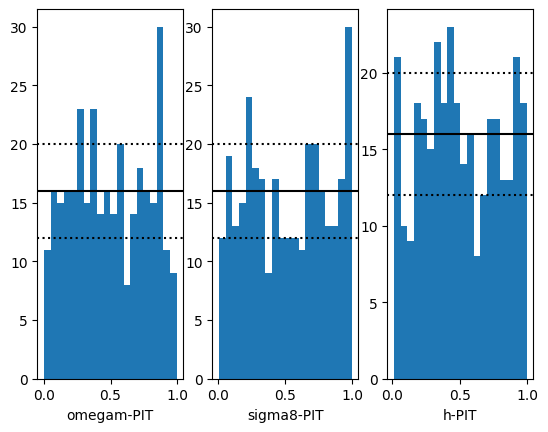

In [38]:
plt.subplot(131)
plt.hist(omegam_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')
plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel('omegam-PIT')

plt.subplot(132)
plt.hist(sigma8_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')

plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel('sigma8-PIT')

plt.subplot(133)
plt.hist(h_cdfs, bins=bins, density=False)
plt.axhline(uniform_layer, color='k')

plt.axhline(uniform_layer - std, color='k', ls=':')
plt.axhline(uniform_layer + std, color='k', ls=':')

plt.xlabel('h-PIT')